In [ ]:
!apt install -y libboost-all-dev

!pip install -U pip
!pip install "pybind11[global]"
!pip install aijack

In [11]:
import os
import time
import copy
import random
from tqdm import tqdm

import numpy as np

import sklearn
from sklearn import datasets
from sklearn.ensemble import IsolationForest
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from aijack.attack import Poison_attack_sklearn

## Dataset

In [3]:
mnist = datasets.fetch_openml("mnist_784", version=1, data_home=".", return_X_y=True)
imagedata, labeldata = mnist[0].values, mnist[1].values

index_3 = [i for i, x in enumerate(labeldata) if x == "3"]
index_7 = [i for i, x in enumerate(labeldata) if x == "7"]
image_data_3_7 = imagedata[index_3 + index_7]
label_data_3_7 = labeldata[index_3 + index_7]

(
    imagedata_training,
    imagedata_validation,
    labeldata_training,
    labeldata_validation,
) = train_test_split(image_data_3_7, label_data_3_7, test_size=0.2, shuffle=True)

imagedata_training = imagedata_training / 255.0
imagedata_validation = imagedata_validation / 255.0

X_train = imagedata_training[:5000]
y_train = labeldata_training[:5000]
X_valid = imagedata_validation[:500]
y_valid = labeldata_validation[:500]

## Training

In [4]:
clf = SVC(kernel="linear")
clf.fit(X_train, y_train)

predict = clf.predict(X_valid)

ac_score = metrics.accuracy_score(y_valid, predict)
cl_report = metrics.classification_report(y_valid, predict)
print(cl_report)

              precision    recall  f1-score   support

           3       0.99      0.98      0.98       250
           7       0.98      0.99      0.98       250

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



## Poisining Attack trial before defense mechanisms

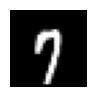

In [5]:
# initial point
initial_idx = np.where(y_train == "7")[0][42]
xc = copy.deepcopy(X_train[initial_idx, :])
yc = y_train[initial_idx]

train_idx = random.sample(list(range(1, X_train.shape[0])), 100)
X_train_ = copy.copy(X_train[train_idx, :])
y_train_ = copy.copy(y_train[train_idx])
y_train_ = np.where(y_train_ == "7", 1, -1)
y_valid_ = np.where(y_valid == "7", 1, -1)

plt.figure(figsize=(1, 1))
plt.imshow(xc.reshape(28, 28), cmap="gray")
plt.axis("off")
plt.show()

after attacking:

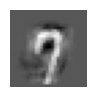

In [6]:
attacker = Poison_attack_sklearn(clf, X_train_, y_train_, t=0.5)
xc_attacked, log = attacker.attack(xc, 1, X_valid, y_valid_, num_iterations=200)
plt.figure(figsize=(1, 1))
plt.imshow(xc_attacked.reshape(28, 28), cmap="gray")
plt.axis("off")
plt.show()

notice performance change:

In [7]:
clf = SVC(kernel="linear", C=1)
clf.fit(X_train_, y_train_)
print("before attack: ", clf.score(X_valid, y_valid_))

# add poinsoned data
clf = SVC(kernel="linear", C=1)
clf.fit(
    np.concatenate([X_train_, xc_attacked.reshape(1, -1)]),
    np.concatenate([y_train_, [-1]]),
)
print("after attack: ", clf.score(X_valid, y_valid_))

before attack:  0.972
after attack:  0.916


### First Defense: Input Sanitization

In [8]:
def bit_depth_reduction(X, bits=4):
    levels = 2 ** bits
    return np.floor(X * levels) / levels

# assemble poisoned set (same as you used)
X_poison = np.concatenate([X_train_, xc_attacked.reshape(1, -1)])
y_poison = np.concatenate([y_train_, [-1]])

# sanitize train + valid, retrain and evaluate
X_poison_san = bit_depth_reduction(X_poison, bits=4)
X_valid_san  = bit_depth_reduction(X_valid, bits=4)

clf_san = SVC(kernel="linear", C=1)
clf_san.fit(X_poison_san, y_poison)
print("defense A (sanitization):", clf_san.score(X_valid_san, y_valid_))

defense A (sanitization): 0.918


### Seconde Defense: Outlier Detection

In [12]:
contamination = max(0.01, 1.0 / max(1, len(X_poison)))
iso = IsolationForest(contamination=contamination, random_state=0)
iso.fit(X_poison)
pred = iso.predict(X_poison)   # 1 = inlier, -1 = outlier
keep_mask = (pred == 1)

# Report whether the appended poisoned sample (last index) was flagged
was_flagged = (pred[-1] == -1)
print("poisoned sample flagged by IsolationForest?:", was_flagged)
print("removed samples:", int(np.sum(pred == -1)), "kept:", int(np.sum(keep_mask)))

# Filter and retrain
X_filtered = X_poison[keep_mask]
y_filtered = y_poison[keep_mask]

clf_clean = SVC(kernel="linear", C=1)
clf_clean.fit(X_filtered, y_filtered)
print("defense B (outlier removal):", clf_clean.score(X_valid, y_valid_))

poisoned sample flagged by IsolationForest?: True
removed samples: 1 kept: 100
defense B (outlier removal): 0.972
